# Ganopolski 2024- Toward generalized Milankovitch theory 


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

import numpy as np
from copy import copy
import matplotlib.pyplot as plt

In [2]:
import paleobeasts as pb
from paleobeasts.signal_models import g24

# Model 3
(From Ganopolski et al. 2024)

## Primary Equations
Change in ice volume is a function of the state of the system (k), the ice volume (v), and time (t). The equation is given by: 

\begin{equation}
\frac{dv}{dt}=
    \begin{cases}
        \frac{(v_{e} - v)}{t_{1}} & \text{  if } k=1\\
        \frac{(-v_{c})}{t_{2}} & \text{  if } k=2
    \end{cases}
\end{equation}

The state of the system ($k$) is determined by the following conditions:
- transition from a glacial (k=1) to deglaciation regime (k = 2) occurs if three conditions are met:
    - v > $v_c$, 
    - dfdt > 0, 
    - f > 0
- The transition from deglaciation (k=2) to glacial (k=1) regime occurs if:
    - f < $f_1$ (where $f_1$ is the insolation threshold for glacial inception)
The interglacial state formally belongs to the deglaciation regime.


### If k=1...
\begin{align}
\frac{dv}{dt} = \frac{(v_{e} - v)}{t_{1}}
\end{align}

#### Equilibrium ice volume $v_{e}$ given a glacial state:
Where $v_{e}$ is the ice volume of the equilibrium state to which the system is attracted:

\begin{equation}
v_{e}=
    \begin{cases}
        v_{g} & \text{  if } f<f_{1} \text{ or } f_{1}<f<f_{2} \text{ and } v>v_{u}\\
        v_{i} & \text{  if } f>f_{2} \text{ or } f_{1}<f<f_{2} \text{ and } v<v_{u}
    \end{cases}
\end{equation}

$f_1$ = insolation threshold for glacial inception (pinned at -20 to -15 W/m^2)
$t_1$ = relaxation timescale for glacial inception (in kyr)
$f_2$ = insolation threshold for deglaciation inception (tunable; positive)

If the forcing is less than the glacial inception threshold ($f_{1}$), the equilibrium ice volume is equilibrium glacial state $v_{g}$ ice volume. If the forcing is greater than the deglaciation threshold ($f_{2}$), the equilibrium ice volume is the equilibrium interglacial ice volume $v_{i}$. 

If the forcing is between the glacial inception threshold ($f_{1}$) and the deglaciation threshold ($f_{2}$), the equilibrium ice volume is determined by whether the current ice volume is greater or less than $v_{u}$, the unstable equilibrium ice volume. Greater and the system will be attracted to the glacial value, less and the system will be attracted to the interglacial value.  

\begin{align}
v_{u} = 1 - \sqrt{\frac{(f_2 - f)}{(f_2 - f_1))}}
\end{align}

The values of $v_{g}$ and $v_{i}$ are given by:
\begin{align}
v_{g} = 1 + \sqrt{\frac{(f_2 - f)}{(f_2 - f_1))}}
v_{i} = 0
\end{align}

#### 

### if k = 2...

\begin{align}
\frac{dv}{dt} = \frac{(-v_{c})}{t_{2}}
\end{align}

$v_{c}$  = value for critical ice volume; controls the dominant periodicity and degree of asymmetry of glacial cycles
$t_2$ = relaxation timescale for deglaciation (in kyr)

$v_{c}$ is a tunable parameter. Ganopolski 2024, includes figures based on a constant value of $v_{c}$ values of 1.2, 1.33 and 1.47 as well as a time dependent value used for exploring the mid Pleistocene transition.

## Code
Note: getting the figure to look like the one in the paper is a bit tricky. The system seems to be fairly sensitive to interval of integration and timestep.

### Forcing by equation
\begin{align}
f = A * (1 + \epsilon * \sin(2 \pi * t / T1)) * \cos(2 \pi * t / T2)
\end{align}

`A` = magnitude of forcing in Wm−2
`eps` = nondimensional magnitude of amplitude modulation

In [111]:
A = 25 #Magnitude of forcing in Wm−2
eps = 0.5 #nondimensional magnitude of eccentricity modulation

# initialize the forcing with calc_f
g24_forcing = pb.Forcing(g24.calc_f, params = {'A':A, 'eps':eps})

In [112]:
f1 = -16 #insolation threshold for glacial inception
f2 = 16 #insolation threshold for deglaciation inception
vc = 1.47 #critical ice volume
t1 = 30 #relaxation timescale for glacial inception
t2 = 10 #relaxation timescale for deglaciation

In [113]:
# Initialize the model
model3 = g24.Model3(forcing=g24_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)

#### Try a few different timestep sizes
It's not clear to me why the model is so sensitive to timestep. I believe the paper says 40kyr, but dt=40kyr won't resolve the small peaks, so I assume that the timestep is actually smaller than that. I found that 6.5 kyr was the timestep that produced a reasonable replication of the paper figure.

In [119]:
length = 1200 #length of simulation in kyr
t_i = 0 #start time
t_f = t_i+length #end time
delta_ts=[2,4, 6.5, 8, 12] #timestep

v_i= 0 #initial ice volume
k_i = 1 #initial state

In [132]:
# Initialize the model
euler_model3s = {}
for dt in delta_ts:
    model3_euler = copy(model3)
    model3_euler.integrate((t_i, t_f), [v_i, k_i], method='euler',kwargs={'dt':dt})
    model3_euler.time = model3_euler.time -length
    euler_model3s[dt]=model3_euler


/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:162: RuntimeWarning: invalid value encountered in sqrt
  return 1 + np.sqrt((self.f2 - f) / (self.f2 - self.f1))
/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:179: RuntimeWarning: invalid value encountered in sqrt
  return 1 - np.sqrt((self.f2 - f) / (self.f2 - self.f1))


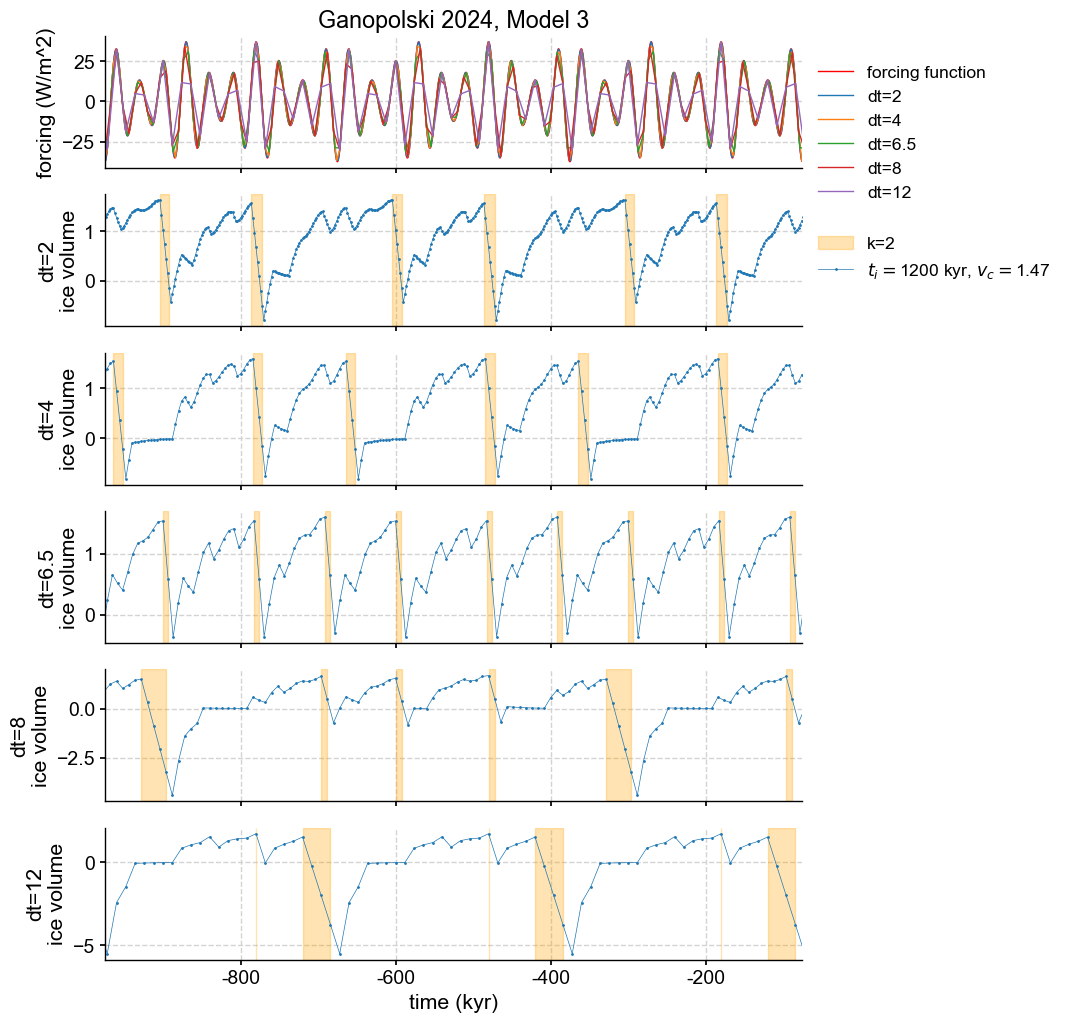

In [136]:
time_axis_limits = (-975, -75)

model_sol = euler_model3s[delta_ts[0]]
t_range = np.arange(min(model_sol.time), max(model_sol.time), .1)

ticks = np.arange(-1000, 5, 200)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(delta_ts) + 1, 1, sharex=True, figsize=(9, 12))

# Plot full orbital forcing
t_range = np.arange(min(model_sol.time), max(model_sol.time), .1)
smooth_forcing = model_sol.forcing.get_forcing(t_range)
ax[0].plot(t_range, smooth_forcing, linewidth=1, label='forcing function', color='red', zorder=0)

for ik, dt in enumerate(delta_ts):
    model_sol = euler_model3s[dt]

    time = model_sol.time  #solution.t#['t_arr']
    k_arr = model_sol.state_variables['k']
    model_sol_y = model_sol.state_variables['v']  #model_sol.solution.y[:,0]

    #DataFrame and sort by 'Time'
    df = pd.DataFrame({'Time': time, 'k': k_arr}).sort_values('Time')
    # Filter out data where 'Time' is less than min(t_range)
    df = df[df['Time'] > min(t_range)]
    # Identify where 'k' changes and calculate 'start' and 'end'
    df['start'] = (df['k'] == 2) & (df['k'].shift(1) != 2)
    df['end'] = (df['k'] == 2) & (df['k'].shift(-1) != 2)

    # Extract intervals
    intervals = [(start, end) for start, end in zip(df.loc[df['start'], 'Time'], df.loc[df['end'], 'Time'])]

    # Handling case where last interval does not end within the data range
    if df.iloc[-1]['k'] == 2 and not df.iloc[-1]['end']:
        intervals.append((df.loc[df['start'], 'Time'].iloc[-1], df.iloc[-1]['Time']))

    model_forcing = model_sol.diagnostic_variables['insolation']
    # model_sol.forcing.get_forcing(model_sol.time_util(time))
    label = ', '.join([r'$t_i=$' + str(length) + ' kyr', r'$v_c=$' + str(model_sol.vc)])

    if len(intervals) > 0:
        for im, interval in enumerate(intervals):
            if im == 0:
                k2label = 'k=2'
            else:
                k2label = None
            ax[ik + 1].axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=k2label)
    ax[ik + 1].plot(time, model_sol_y, linewidth=.5, marker='o', markersize=1, label=label)

    if ik == 1:
        ax[ik + 1].legend(loc='upper left', bbox_to_anchor=(1, 2))

    ax[0].plot(time[1:], model_forcing, linewidth=1, label='dt={}'.format(dt))

    ax[0].set_ylabel('forcing (W/m^2)')
    ax[ik + 1].set_xticks(ticks)
    ax[ik + 1].set_ylabel('\n'.join(['dt={}'.format(dt), model_sol.variable_name]))

ax[-1].set_xlim(time_axis_limits)
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time (kyr)')
ax[0].set_title('Ganopolski 2024, Model 3')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, .9))
# plt.savefig('figures/g24_model3_euler_vc1p47.png')

### Forcing by orbital time series

In [13]:
import os
from pathlib import Path
import pandas as pd
proj_dir = Path(os.getcwd()).parent

In [137]:
# Load orbital forcing
orbital_full = pd.read_csv(proj_dir/'paleobeasts/data/insolation.csv', index_col=0)

# Initialize the forcing
orb_forcing = pb.Forcing(orbital_full['insol_65N_d172'].values-orbital_full['insol_65N_d172'].mean(), time=orbital_full['kyear'], interpolation='cubic')

data is an array


In [78]:
# Initialize the model
vc = 1.4 #critical ice volume
model3_orb_root = g24.Model3(forcing=orb_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)

# Add derivative function to model based on forcing data
dfdt = pb.utils.utilities.make_derivative_func(method='numpy', derivative=None, data=orb_forcing.data, time=orb_forcing.time)
model3_orb_root.dfdt = dfdt

Ganoploski says that the trajectories converge within 200 kyr, which we confirm in the plot below. For each timestep size, the model is integrated with a different start time and running to 0kya.

In [79]:
delta_ts=[1,2,4,6.5] #timestep
v_i= 0 #initial ice volume
k_i = 1 #initial state

In [80]:
# Integrate the model for different timesteps
from collections import defaultdict
euler_model3s = defaultdict(dict)

integration_t_i = 0 #start time
lengths  = [1050,1000, 980, 950, 900]
for dt in delta_ts:
    for length in lengths:
        integration_t_f = integration_t_i+length
        model3_euler = copy(model3_orb_root)
        
        # add time_util to model to handle conversion between integration stepping time and forcing time
        model3_euler.time_util= lambda x: -5000+ (5000-integration_t_f) +x
        
        model3_euler.integrate((integration_t_i, integration_t_f), [v_i, k_i], method='euler',kwargs={'dt':dt})
        model3_euler.time = model3_euler.time -length
        euler_model3s[dt][length]=model3_euler


/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:162: RuntimeWarning: invalid value encountered in sqrt
  return 1 + np.sqrt((self.f2 - f) / (self.f2 - self.f1))
/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:179: RuntimeWarning: invalid value encountered in sqrt
  return 1 - np.sqrt((self.f2 - f) / (self.f2 - self.f1))


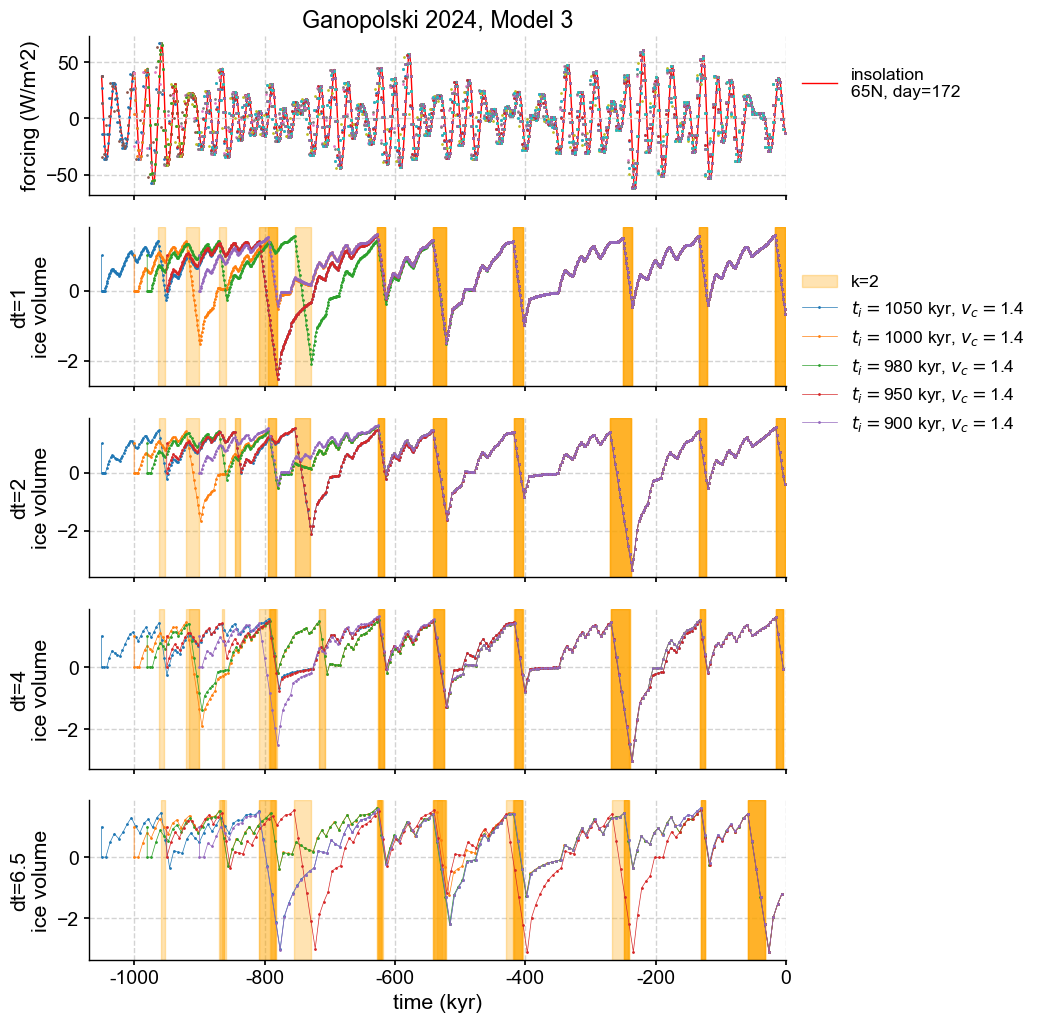

In [110]:
time_axis_limits=(-1070, 0)

model_sol = euler_model3s[delta_ts[0]][max(lengths)]
t_range = np.arange(min(model_sol.time), max(model_sol.time), .1)

ticks = np.arange(-1000, 5, 200)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(delta_ts)+1, 1, sharex=True, figsize=(9, 12))

# Plot full orbital forcing
t_range = np.arange(min(model_sol.time), max(model_sol.time), .1)
smooth_forcing = model_sol.forcing.get_forcing(t_range)
ax[0].plot(t_range, smooth_forcing, linewidth=1, label='\n'.join(['insolation', '65N, day=172']), color='red', zorder=0)

for ik, dt in enumerate(delta_ts):
    for ip, length in enumerate(euler_model3s[dt].keys()):
        model_sol = euler_model3s[dt][length]

        time = model_sol.time#solution.t#['t_arr']
        k_arr = model_sol.state_variables['k']
        model_sol_y = model_sol.state_variables['v']#model_sol.solution.y[:,0]
    
        #DataFrame and sort by 'Time'
        df = pd.DataFrame({'Time': time, 'k': k_arr}).sort_values('Time')
        # Filter out data where 'Time' is less than min(t_range)
        df = df[df['Time'] > min(t_range)]
        # Identify where 'k' changes and calculate 'start' and 'end'
        df['start'] = (df['k'] == 2) & (df['k'].shift(1) != 2)
        df['end'] = (df['k'] == 2) & (df['k'].shift(-1) != 2)

        # Extract intervals
        intervals = [(start, end) for start, end in zip(df.loc[df['start'], 'Time'], df.loc[df['end'], 'Time'])]

        # Handling case where last interval does not end within the data range
        if df.iloc[-1]['k'] == 2 and not df.iloc[-1]['end']:
            intervals.append((df.loc[df['start'], 'Time'].iloc[-1], df.iloc[-1]['Time']))

        model_forcing = model_sol.diagnostic_variables['insolation']
        # model_sol.forcing.get_forcing(model_sol.time_util(time))
        label=', '.join([r'$t_i=$'+str(length)+' kyr',r'$v_c=$'+str(model_sol.vc)])
        
        if len(intervals)>0:
            for im, interval in enumerate(intervals):
                if im==0:
                    if ip==0:
                        k2label='k=2'
                else:
                    k2label=None
                ax[ik+1].axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=k2label)
        ax[ik+1].plot(time, model_sol_y, linewidth=.5, marker='o', markersize=1, label=label)
                
        if ik == 1:
            ax[ik+1].legend(loc='upper left', bbox_to_anchor=(1,2))

        ax[0].scatter(time[:-1], model_forcing, s=1)#, label='dt={}'.format(dt))

    ax[0].set_ylabel('forcing (W/m^2)')
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join(['dt={}'.format(dt),model_sol.variable_name]))

ax[-1].set_xlim(time_axis_limits)
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time (kyr)')
ax[0].set_title('Ganopolski 2024, Model 3')
ax[0].legend(loc = 'upper left', bbox_to_anchor=(1,.9))
# plt.savefig('figures/g24_model3_euler_vc1p47.png')

# Archive

In [124]:
# Integrate the model for different timesteps
from collections import defaultdict
euler_model3_simple_forcing = defaultdict(dict)

integration_t_i = 0 #start time
lengths  = [1200]
for dt in delta_ts:
    for length in lengths:
        integration_t_f = integration_t_i+length
        model3_euler = copy(model3)        
        model3_euler.integrate((integration_t_i, integration_t_f), [v_i, k_i], method='euler',kwargs={'dt':dt})
        model3_euler.time = model3_euler.time -length
        euler_model3_simple_forcing[dt][length]=model3_euler


/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:162: RuntimeWarning: invalid value encountered in sqrt
  return 1 + np.sqrt((self.f2 - f) / (self.f2 - self.f1))
/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/g24.py:179: RuntimeWarning: invalid value encountered in sqrt
  return 1 - np.sqrt((self.f2 - f) / (self.f2 - self.f1))


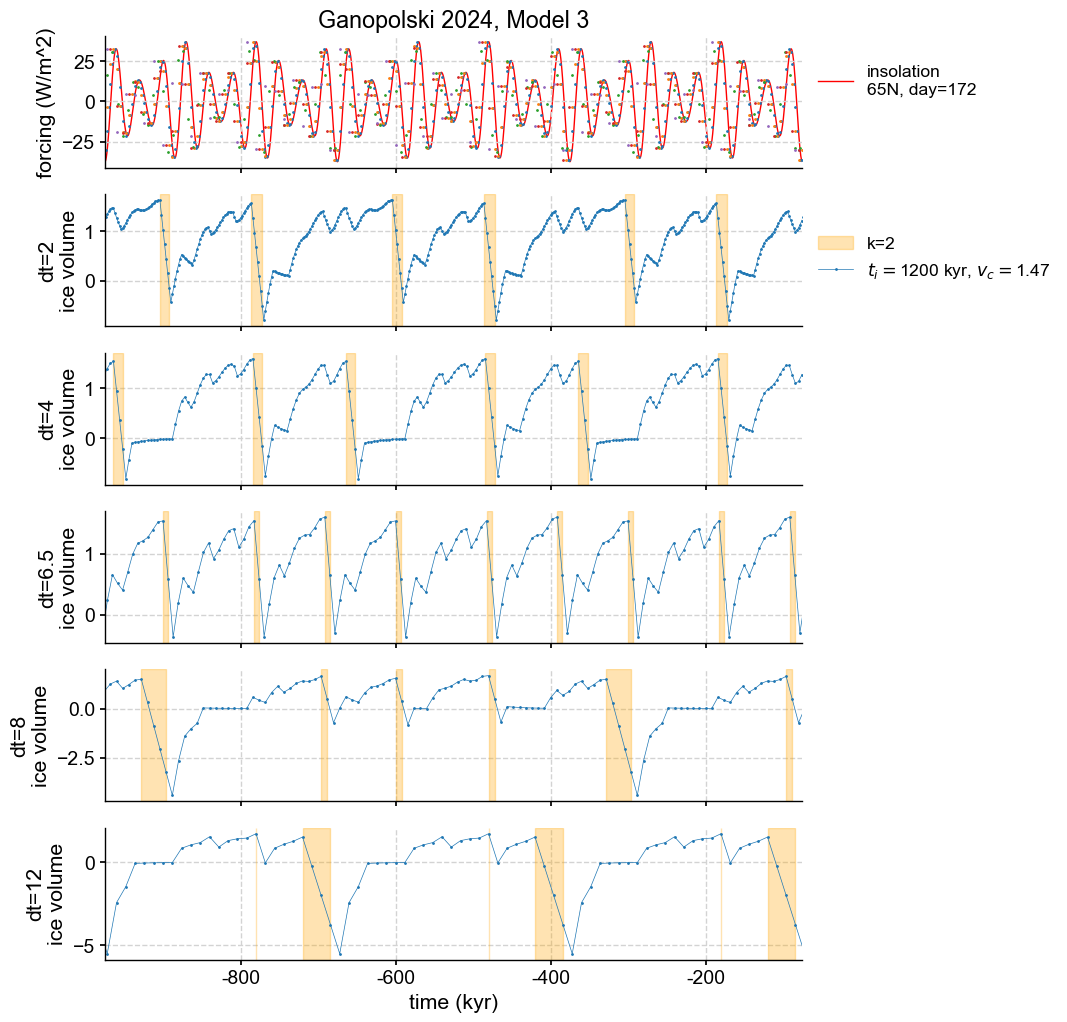

In [131]:
time_axis_limits=(-975, -75)


model_sol = euler_model3_simple_forcing[delta_ts[0]][max(lengths)]
t_range = np.arange(min(model_sol.time), max(model_sol.time), .1)

ticks = np.arange(-1000, 5, 200)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(delta_ts)+1, 1, sharex=True, figsize=(9, 12))

# Plot full orbital forcing
t_range = np.arange(min(model_sol.time), max(model_sol.time), .1)
smooth_forcing = model_sol.forcing.get_forcing(t_range)
ax[0].plot(t_range, smooth_forcing, linewidth=1, label='\n'.join(['insolation', '65N, day=172']), color='red', zorder=0)

for ik, dt in enumerate(delta_ts):
    for ip, length in enumerate(euler_model3_simple_forcing[dt].keys()):
        model_sol = euler_model3_simple_forcing[dt][length]

        time = model_sol.time#solution.t#['t_arr']
        k_arr = model_sol.state_variables['k']
        model_sol_y = model_sol.state_variables['v']#model_sol.solution.y[:,0]
    
        #DataFrame and sort by 'Time'
        df = pd.DataFrame({'Time': time, 'k': k_arr}).sort_values('Time')
        # Filter out data where 'Time' is less than min(t_range)
        df = df[df['Time'] > min(t_range)]
        # Identify where 'k' changes and calculate 'start' and 'end'
        df['start'] = (df['k'] == 2) & (df['k'].shift(1) != 2)
        df['end'] = (df['k'] == 2) & (df['k'].shift(-1) != 2)

        # Extract intervals
        intervals = [(start, end) for start, end in zip(df.loc[df['start'], 'Time'], df.loc[df['end'], 'Time'])]

        # Handling case where last interval does not end within the data range
        if df.iloc[-1]['k'] == 2 and not df.iloc[-1]['end']:
            intervals.append((df.loc[df['start'], 'Time'].iloc[-1], df.iloc[-1]['Time']))

        model_forcing = model_sol.diagnostic_variables['insolation']
        # model_sol.forcing.get_forcing(model_sol.time_util(time))
        label=', '.join([r'$t_i=$'+str(length)+' kyr',r'$v_c=$'+str(model_sol.vc)])
        
        if len(intervals)>0:
            for im, interval in enumerate(intervals):
                if im==0:
                    if ip==0:
                        k2label='k=2'
                else:
                    k2label=None
                ax[ik+1].axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=k2label)
        ax[ik+1].plot(time, model_sol_y, linewidth=.5, marker='o', markersize=1, label=label)
                
        if ik == 1:
            ax[ik+1].legend(loc='upper left', bbox_to_anchor=(1,2))

        ax[0].scatter(time[:-1], model_forcing, s=1)#, label='dt={}'.format(dt))

    ax[0].set_ylabel('forcing (W/m^2)')
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join(['dt={}'.format(dt),model_sol.variable_name]))

ax[-1].set_xlim(time_axis_limits)
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time (kyr)')
ax[0].set_title('Ganopolski 2024, Model 3')
ax[0].legend(loc = 'upper left', bbox_to_anchor=(1,.9))
# plt.savefig('figures/g24_model3_euler_vc1p47.png')